# Image classification for Caltech101 | Airplanes, Motorbikes & Schooners dastaset!

<table><tr>
<td> <img src="./image_0005.jpg" style="width: 200px; height: 180px;"/> </td>
<td> <img src="./image_0001.jpg" style="width: 200px; height: 180px;"/> </td>
<td> <img src="./image_0003.jpg" style="width: 200px; height: 180px;"/> </td>
</tr></table>

## Challenge
Multiclass image classification for Caltech101 | Airplanes, Motorbikes & Schooners dastaset using CNN and tensorflow 2.0

## Dataset
Dataset contains following 3 classes of non-uniform 2D images with different resolutions:
<ol>
    <li>Airplanes : 800 images</li>
    <li>Motorbikes : 798 images</li>
    <li>Schooner : 63 images</li>
 </ol>

### This blog post covers the following aspects of multiclass image classification using 2D CNN
#### 1. Building a 2D CNN based image classifier for multi class labels using Tensorflow 2.0
<ul>
    <li>Data visualization, pre-possessing and data loading</li>
    <li>Create model, training , performance evaluation and training curves</li>
</ul>

#### 2. Experiment:  Effect of depth on model performance 
<ul>
    <li>Create models with varying depths</li>
    <li>Plot number of layers vs accuracy</li>
</ul>

#### 3. Experiment:  Effect of drop out fraction on model performance 
<ul>
    <li>Create models with varying amount of drop out in the final layer</li>
    <li>Plot drop out fraction vs accuracy</li>
</ul>

#### 4. Observations:  
<ul>
    <li>Best validation performance is observed at number of layers =3(2-conv2D layers, 1-Dense layer)</li>
    <li>Overfitting and reduced accuracy for both training and validation data is observed when number of layers is greater than 3. This is likely due to overfitting in atleast one class</li>
    <li>Using any amount of dropout in penultimate layer has resulted in decreased performance.</li>
</ul>

#### 5. Building model with optimal number of layers and drop out fraction:  
<ul>
    <li>Create model with 3 layers(2 conv2D and 1 dense layer) and 0.1 dropout</li>
    <li>Evaluate performance by creating classification report</li>
</ul>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Rescaling, Dropout
from tensorflow.keras.models import Sequential
seed_value = 332
tf.keras.backend.clear_session()
from sklearn.metrics import classification_report, balanced_accuracy_score
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

### Data visualization, pre-possessing and data loading

In [3]:
#Note: Replace 'str_dir' with your path to data directory
str_dir = 'D:\Fall 2022\Data Mining_CSE 5334\Assignments\Assignment1\Data\caltech101_classification'
data_dir = pathlib.Path(str_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total number of images in dataset: {image_count}')

Total number of images in dataset: 1661


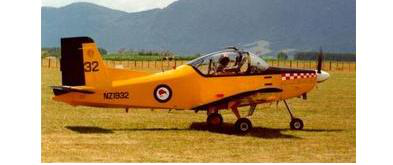

In [4]:
# visualizing sample from class: Airplanes
airplanes = list(data_dir.glob('airplanes/*'))
airplane_sample = PIL.Image.open(str(airplanes[2]))
airplane_sample

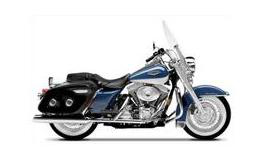

In [5]:
# visualizing sample from class: Motorbikes
motorbikes = list(data_dir.glob('Motorbikes/*'))
morobike_sample = PIL.Image.open(str(motorbikes[0]))
morobike_sample

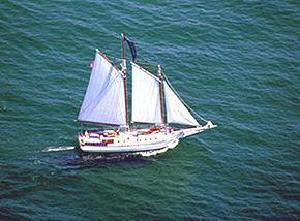

In [6]:
# visualizing sample from class: Schooners
schooners = list(data_dir.glob('schooner/*'))
schooner_sample = PIL.Image.open(str(schooners[2]))
schooner_sample

In [7]:
#Data partitioning
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
              data_dir,
              validation_split=0.2,
              subset="training",
              seed=seed_value,
              image_size=(img_height, img_width),
              batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
              data_dir,
              validation_split=0.2,
              subset="validation",
              seed=seed_value,
              image_size=(img_height, img_width),
              batch_size=batch_size)

class_names = ['Motorbikes','airplanes','schooner']

Found 1661 files belonging to 3 classes.
Using 1329 files for training.
Found 1661 files belonging to 3 classes.
Using 332 files for validation.


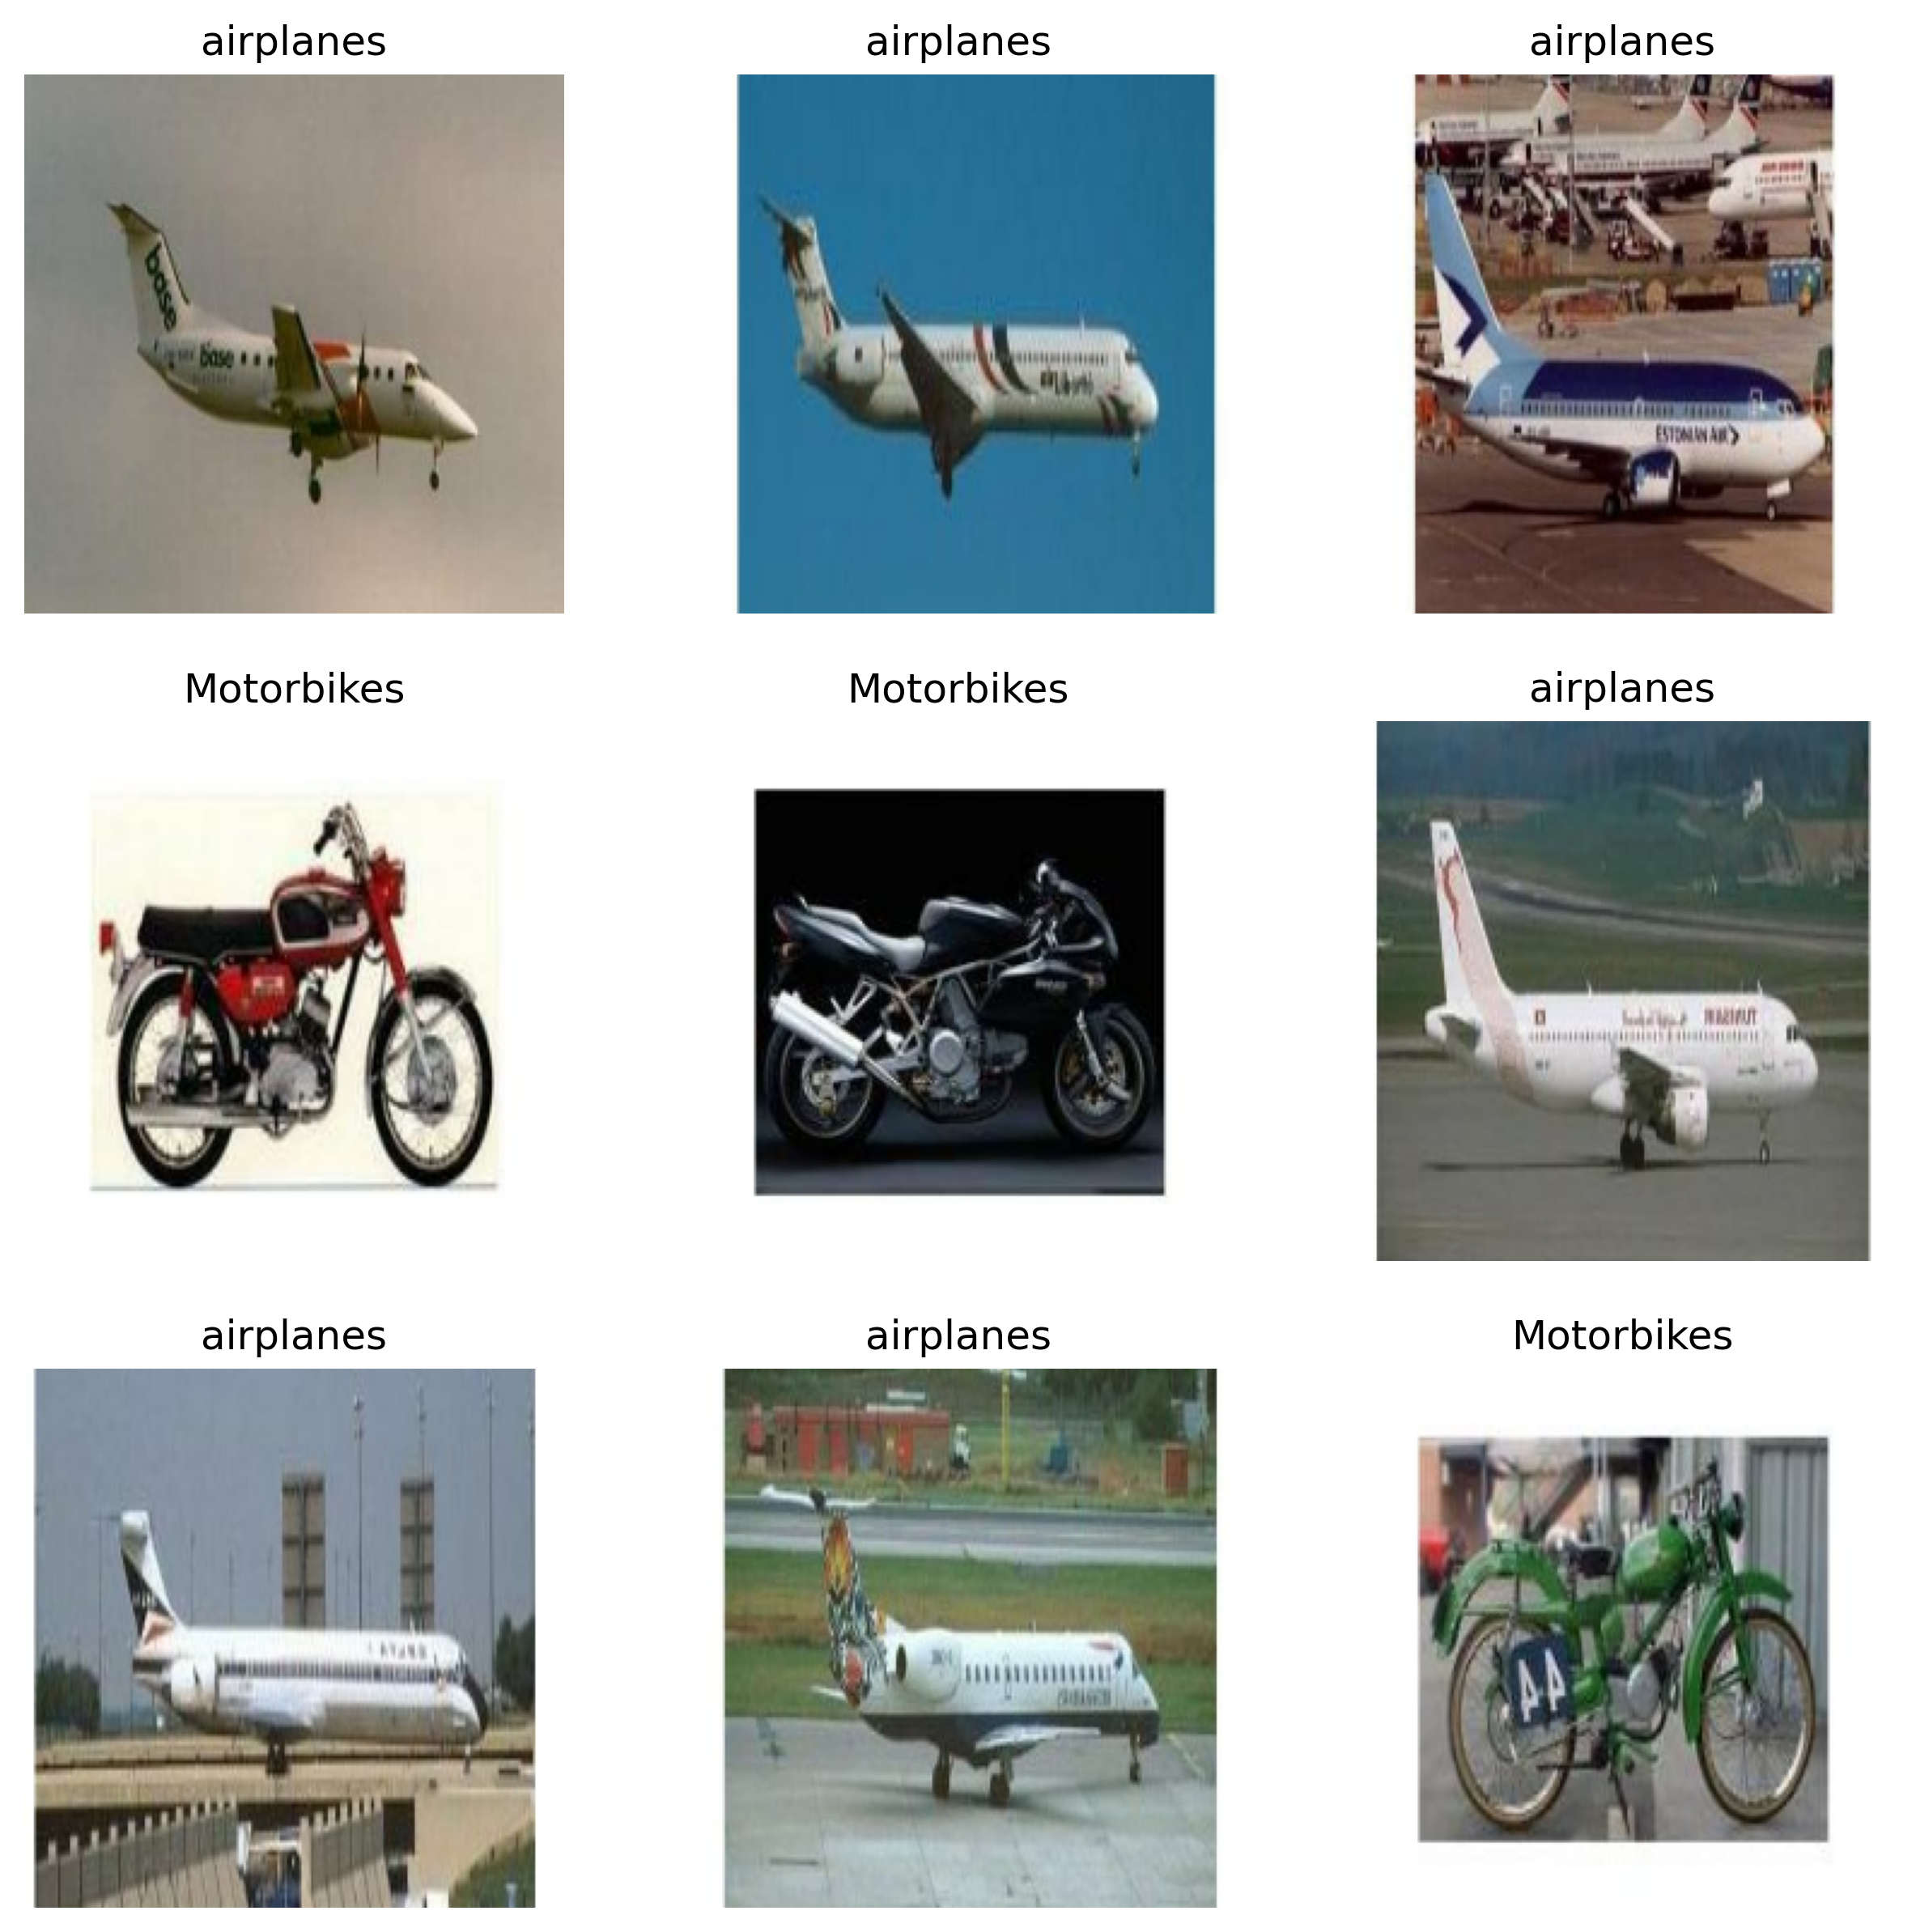

In [8]:
#visualizing samples from each class
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [9]:
#prefetching the data for efficient dataloading
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Create model, training , performance evaluation and training curves

In [10]:
#Here I am using keras sequential API. Later in this blog post, I will use keras functional API to build the model.
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','sparse_categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [11]:
#training
epochs =3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/3
42/42 [==============================] - 23s 542ms/step - loss: 0.8960 - accuracy: 0.7126 - sparse_categorical_accuracy: 0.7126 - val_loss: 0.1973 - val_accuracy: 0.9247 - val_sparse_categorical_accuracy: 0.9247
Epoch 2/3
42/42 [==============================] - 22s 527ms/step - loss: 0.0849 - accuracy: 0.9759 - sparse_categorical_accuracy: 0.9759 - val_loss: 0.1486 - val_accuracy: 0.9428 - val_sparse_categorical_accuracy: 0.9428
Epoch 3/3
42/42 [==============================] - 23s 560ms/step - loss: 0.0393 - accuracy: 0.9880 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.1412 - val_accuracy: 0.9578 - val_sparse_categorical_accuracy: 0.9578


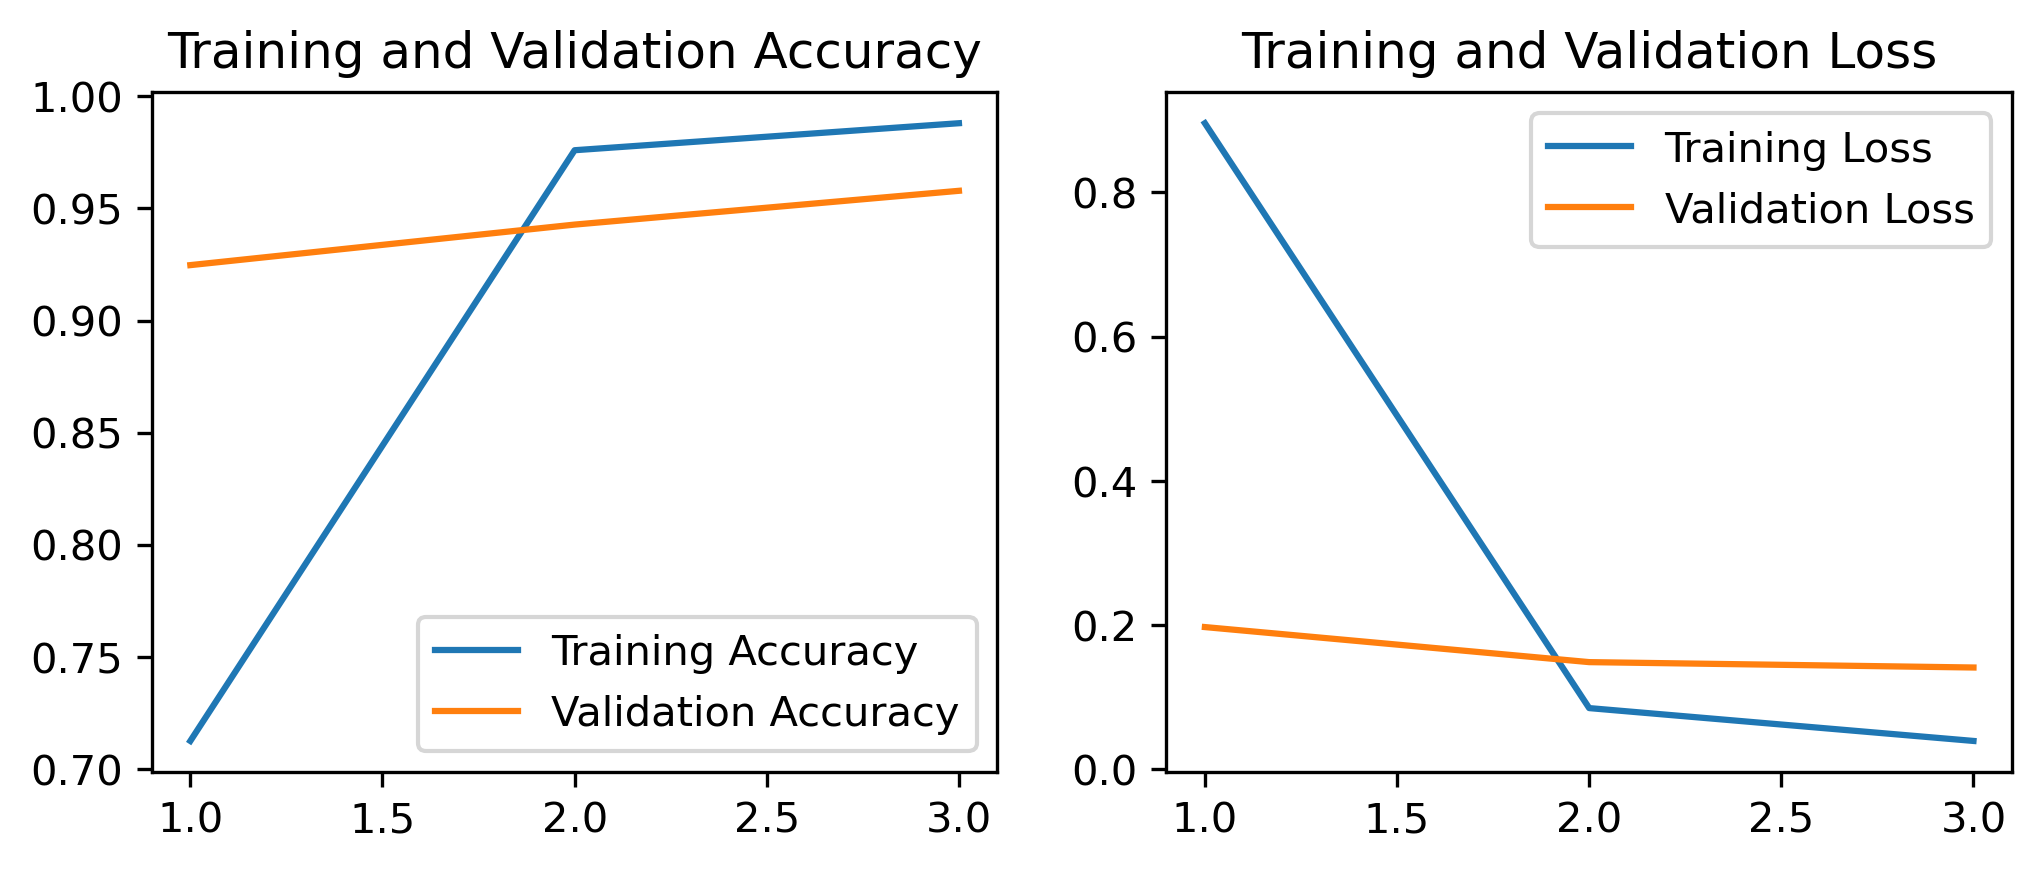

In [12]:
#visualizing the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = [1,2,3]

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [13]:
# compute classification metrics , precision, recall, F1 score on validation data

y_pred = model.predict(val_ds)
score = tf.nn.softmax(y_pred)
predicted_labels = np.argmax(score,axis =1)
ls_val_labels =[]
for img,label in val_ds:
    ls_val_labels.append(label)

correct_labels = tf.concat([item for item in ls_val_labels], axis = 0)    

print(classification_report(correct_labels, predicted_labels, target_names=class_names))

11/11 [==============================] - 2s 121ms/step
              precision    recall  f1-score   support

  Motorbikes       0.92      1.00      0.96       146
   airplanes       0.99      0.92      0.96       167
    schooner       1.00      0.95      0.97        19

    accuracy                           0.96       332
   macro avg       0.97      0.96      0.96       332
weighted avg       0.96      0.96      0.96       332



## Experiment: Effect of depth on model performance 
 Write a function to build 2D CNN model with given number of layers and dropout fraction. Note that here I am using keras functional API to build the 2D CNN model. 

In [14]:
def make_model(num_layers, dropout_frac = 0):
    layer_filters = [16, 32, 64,128,256]
    num_classes = len(class_names)
    inputs = Input(shape=(img_height, img_width, 3))
    x = inputs
    x = Rescaling(1./255, )(x)
    for num in range(num_layers-1):
        x = Conv2D(layer_filters[num], 3, padding='same', activation='relu')(x)
        x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(layer_filters[num+1], activation = 'relu')(x)
    x = Dropout(dropout_frac)(x)
    x = Dense(num_classes)(x)
    
    model = Model(inputs = inputs,outputs = x)
    
    
    model.summary()
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model


Create models with varying depth and plot the effect.

In [15]:
ls_num_layers = [2,3,4,5]
ls_val_accuracy =[]
ls_train_accuracy =[]

for i in ls_num_layers:
    tf.keras.backend.clear_session()
    m = make_model(i)
    
    epochs =3
    print(f'---------------------Training model with {i} layers------------------------')
    history = m.fit(train_ds, validation_data=val_ds, epochs=epochs)
    # compute classification metrics , precision, recall, F1 score on validation dataset

    y_pred = m.predict(val_ds)
    score = tf.nn.softmax(y_pred)
    y_pred_train = m.predict(train_ds)
    score_train = tf.nn.softmax(y_pred_train)
    
    val_predicted_labels = np.argmax(score,axis =1)
    train_predicted_labels = np.argmax(score_train, axis=1)
    
    ls_val_labels =[]
    for img,label in val_ds:
        ls_val_labels.append(label)
        
    ls_train_labels =[]
    for img,label in train_ds:
        ls_train_labels.append(label)

    correct_labels_val = tf.concat([item for item in ls_val_labels], axis = 0)  
    correct_labels_train = tf.concat([item for item in ls_train_labels], axis = 0)
    validation_accuracy = balanced_accuracy_score(correct_labels_val,val_predicted_labels)
    train_accuracy = balanced_accuracy_score(correct_labels_train,train_predicted_labels)
   
    ls_val_accuracy.append(validation_accuracy)
    ls_train_accuracy.append(train_accuracy)
    


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 32)                6422560   
                                                             

 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 flatten (

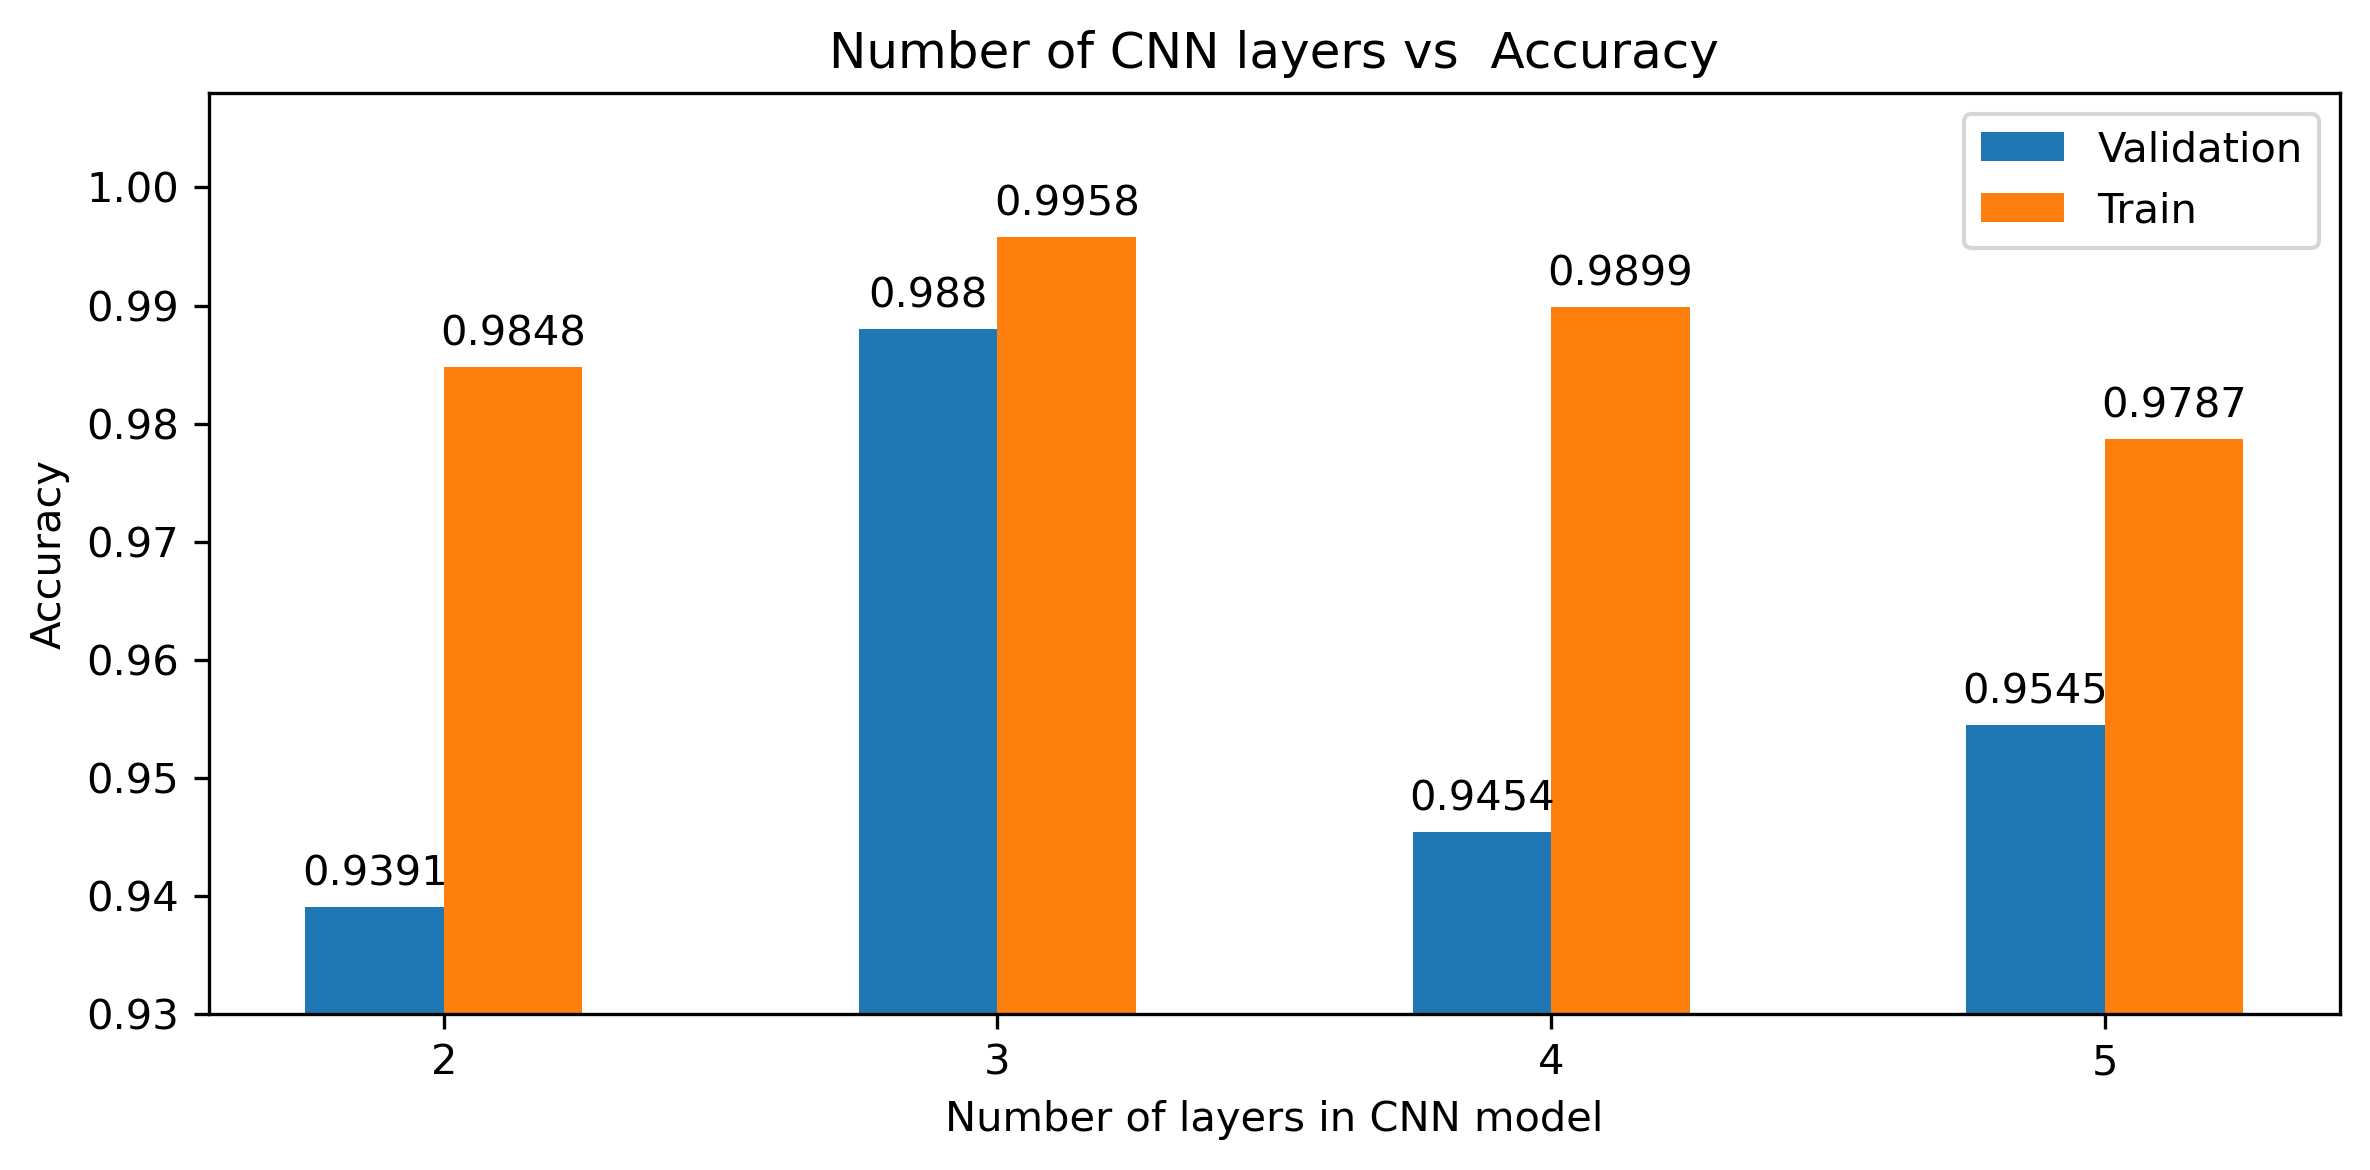

In [16]:
# Barplot --  effect of # of CNN layers VS Accuracy    
layers = ['2', '3', '4', '5']
x = np.arange(len(layers)) 
width = 0.25  
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
rects1 = ax.bar(x - width/2, np.round(ls_val_accuracy,4), width, label='Validation')
rects2 = ax.bar(x + width/2, np.round(ls_train_accuracy,4), width, label='Train')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of layers in CNN model')
ax.set_title('Number of CNN layers vs  Accuracy')
ax.set_xticks(x, layers)
ax.set_ylim([0.93,1.008])
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.show()

 ## Experiment:  Effect of drop out fraction on model performance 

In [17]:
num_layers = 3
ls_dropout_frac = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
ls_val_accuracy =[]
ls_train_accuracy =[]

for i in ls_dropout_frac:
    tf.keras.backend.clear_session()
    m = make_model(num_layers,i)
    
    epochs =3
    print(f'---------------------Training model with {i} drop out fraction ------------------------')
    history = m.fit(train_ds, validation_data=val_ds, epochs=epochs)
    # compute classification metrics , precision, recall, F1 score on validation dataset

    y_pred = m.predict(val_ds)
    score = tf.nn.softmax(y_pred)
    y_pred_train = m.predict(train_ds)
    score_train = tf.nn.softmax(y_pred_train)
    
    val_predicted_labels = np.argmax(score,axis =1)
    train_predicted_labels = np.argmax(score_train, axis=1)
    
    ls_val_labels =[]
    for img,label in val_ds:
        ls_val_labels.append(label)
        
    ls_train_labels =[]
    for img,label in train_ds:
        ls_train_labels.append(label)

    correct_labels_val = tf.concat([item for item in ls_val_labels], axis = 0)  
    correct_labels_train = tf.concat([item for item in ls_train_labels], axis = 0)
    validation_accuracy = balanced_accuracy_score(correct_labels_val,val_predicted_labels)
    train_accuracy = balanced_accuracy_score(correct_labels_train,train_predicted_labels)
   
    ls_val_accuracy.append(validation_accuracy)
    ls_train_accuracy.append(train_accuracy)
    


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                         

                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 6,427,875
Trainable params: 6,427,875
Non-trainable params: 0


                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 6,427,875
Trainable params: 6,427,875
Non-trainable params: 0
_________________________________________________________________
---------------------Training model with 0.7 drop out fraction ------------------------
Epoch 1/3
42/42 [==============================] - 19s 444ms/step - loss: 1.7336 - accuracy: 0.5847 - val_loss: 0.4060 - val_accuracy: 0.8765
Epoch 2/3
42/42 [==============================] - 19s 445ms/step - loss: 0.4270 - accuracy: 0.8269 - val_loss: 0.1878 - val_accuracy: 0.9157
Epoch 3/3
42/42 [==============================] - 5s 115ms/step


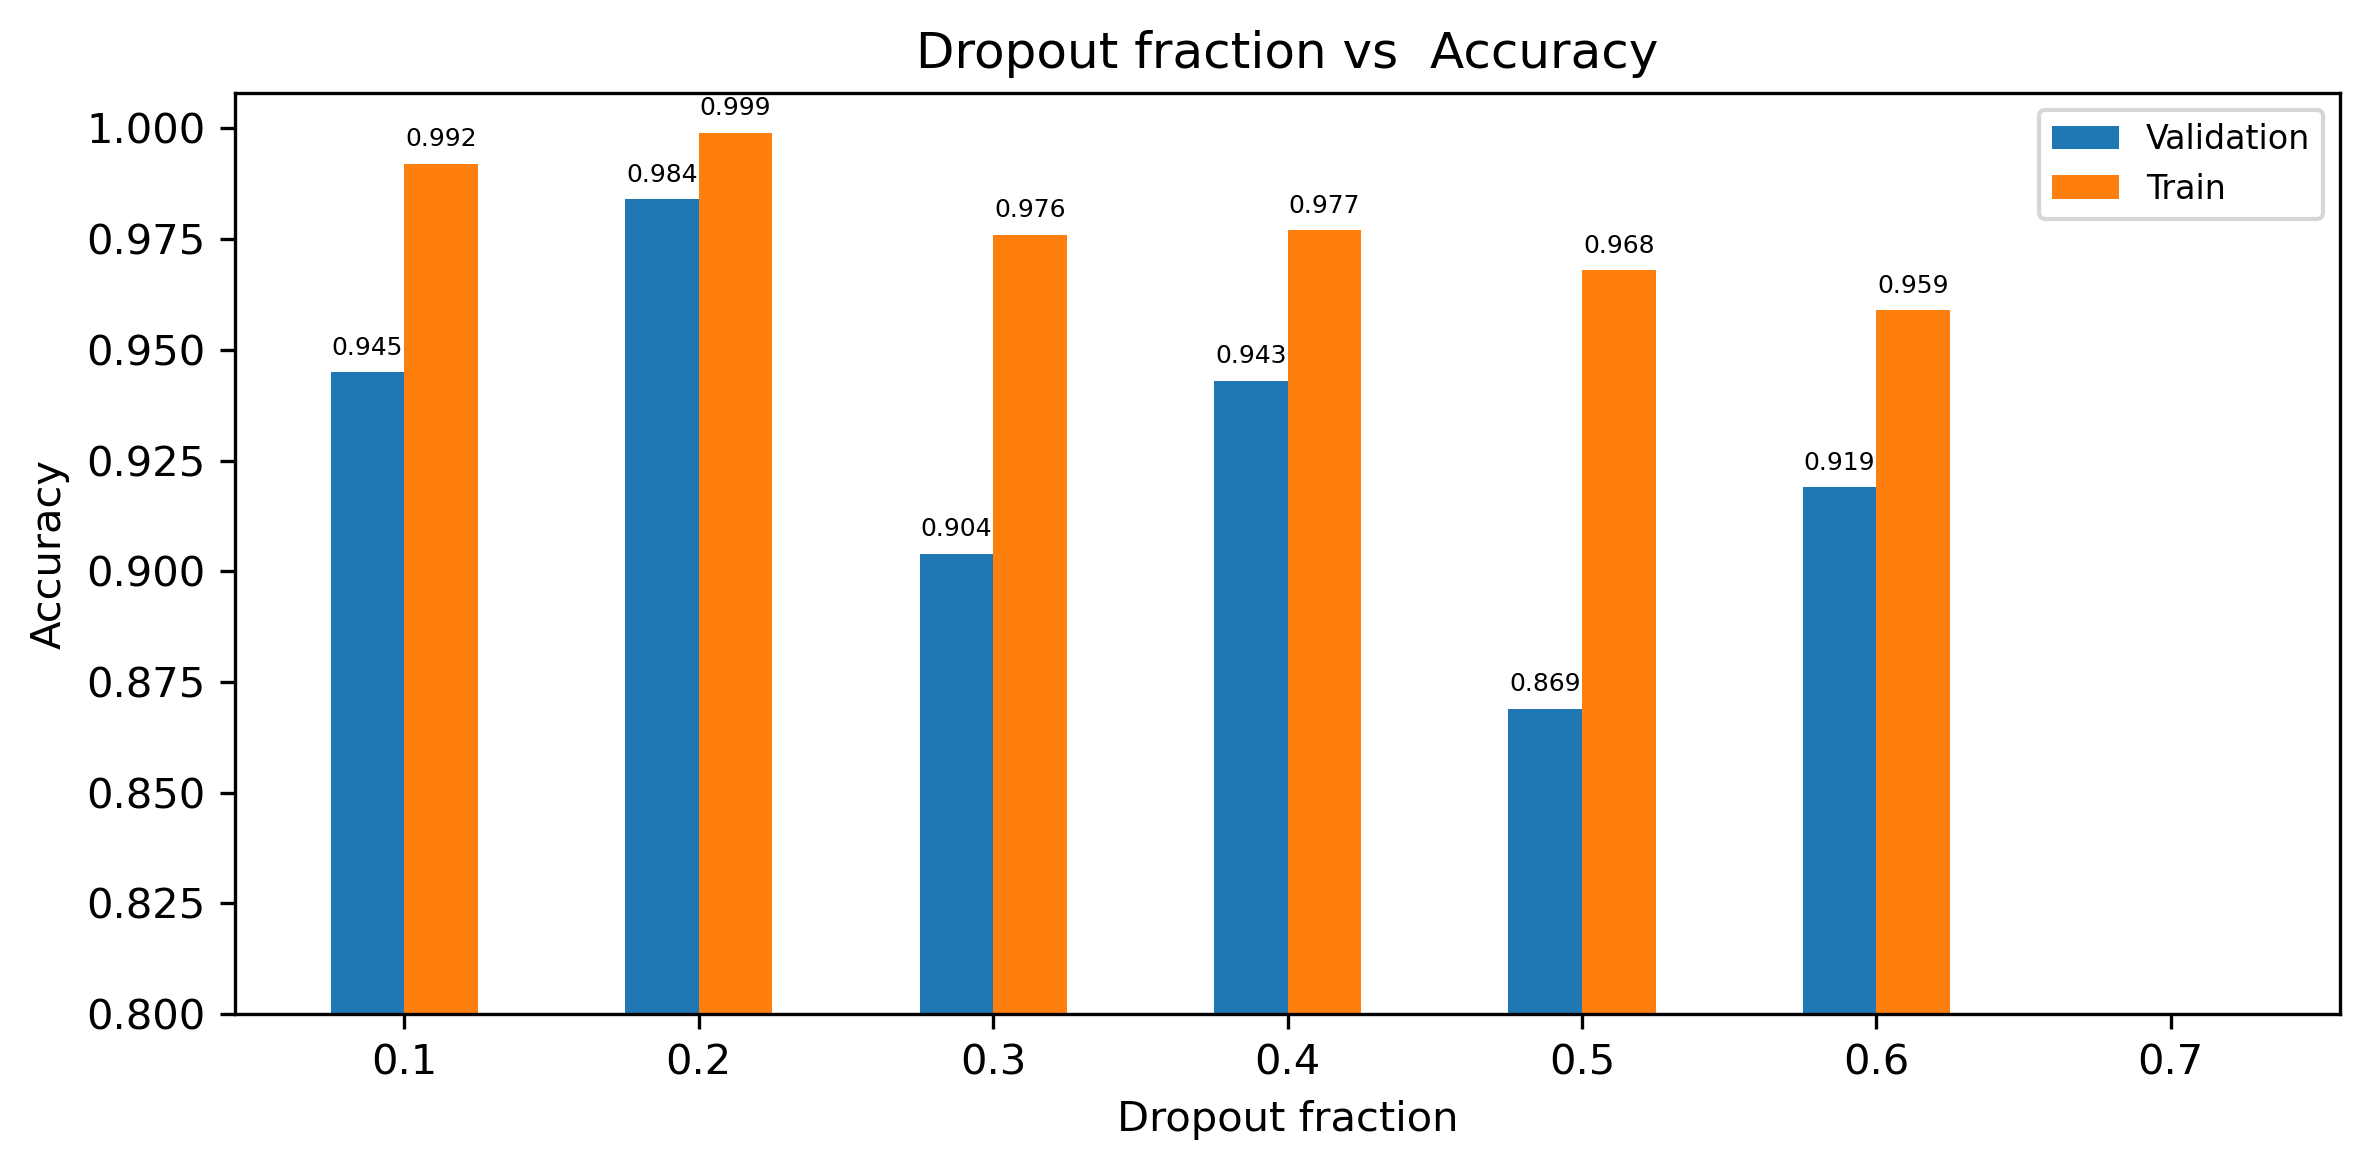

In [18]:
# Barplot --  effect of # of CNN layers including dense layers VS Accuracy    
dropout_frac = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7']
x = np.arange(len(dropout_frac)) 
width = 0.25  
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
rects1 = ax.bar(x - width/2, np.round(ls_val_accuracy,3), width, label='Validation')
rects2 = ax.bar(x + width/2, np.round(ls_train_accuracy,3), width, label='Train')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Dropout fraction')
ax.set_title('Dropout fraction vs  Accuracy')
ax.set_xticks(x, dropout_frac)
ax.set_ylim([0.80,1.008])
ax.legend(fontsize = 8)
ax.bar_label(rects1, padding=3, fontsize = 6)
ax.bar_label(rects2, padding=3,fontsize = 6)
fig.tight_layout()
plt.show()

## Building model with optimal number of layers and drop out fraction

### Results: 
Accuracy for 3 classes is observed to be <b>98%</b>. Precision, recall and f1-score for each class of images is as follows.
<table style='font-size:130%'>
    <tr>
        <td></td>
        <td>Precision</td>
        <td>Recall</td>
        <td>F1-score</td>
    </tr>
    <tr>
        <td>Motorbikes</td>
        <td>0.97</td>
        <td>1.00</td>
        <td>0.98</td>
    </tr>
    <tr>
        <td>Airplanes</td>
        <td>1.00</td>
        <td>0.97</td>
        <td>0.98</td>
    </tr>
    <tr>
        <td>Schooners</td>
        <td>0.95</td>
        <td>0.95</td>
        <td>0.95</td>
    </tr>
</table>


In [19]:
num_layers = 3
dropout_frac = 0.1

tf.keras.backend.clear_session()
m = make_model(num_layers,dropout_frac)

epochs =3
print(f'---------------------Training model with {num_layers} layers and {dropout_frac} drop out fraction ------------------------')
history = m.fit(train_ds, validation_data=val_ds, epochs=epochs)
# compute classification metrics , precision, recall, F1 score on validation dataset

y_pred = m.predict(val_ds)
score = tf.nn.softmax(y_pred)
predicted_labels = np.argmax(score,axis =1)
ls_val_labels =[]
for img,label in val_ds:
    ls_val_labels.append(label)

correct_labels = tf.concat([item for item in ls_val_labels], axis = 0)    
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                         

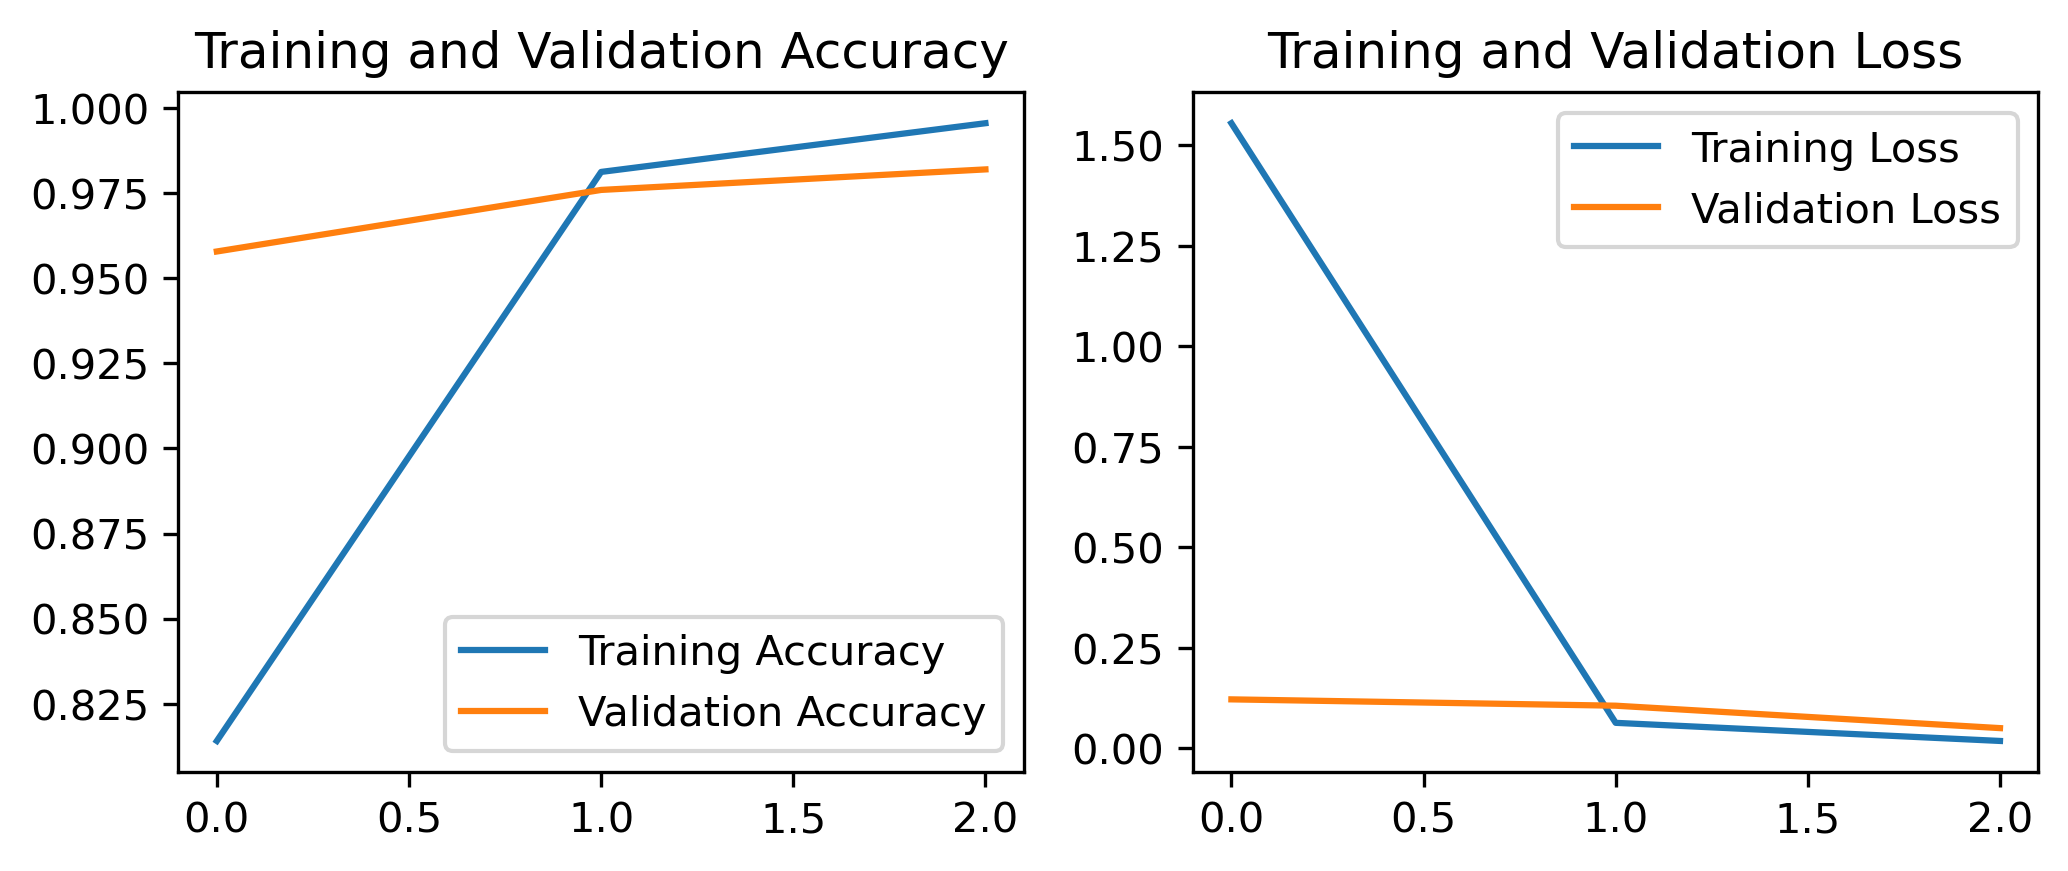

In [20]:
#visualizing the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [21]:
# compute classification metrics , precision, recall, F1 score on validation data

y_pred = m.predict(val_ds)
score = tf.nn.softmax(y_pred)
predicted_labels = np.argmax(score,axis =1)
ls_val_labels =[]
for img,label in val_ds:
    ls_val_labels.append(label)

correct_labels = tf.concat([item for item in ls_val_labels], axis = 0)    

print(classification_report(correct_labels, predicted_labels, target_names=class_names))

11/11 [==============================] - 1s 113ms/step
              precision    recall  f1-score   support

  Motorbikes       0.97      1.00      0.98       146
   airplanes       1.00      0.97      0.98       167
    schooner       0.95      0.95      0.95        19

    accuracy                           0.98       332
   macro avg       0.97      0.97      0.97       332
weighted avg       0.98      0.98      0.98       332

